## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as im
import pickle
from project import gradients, region_of_interest, get_points, Camera
from moviepy.editor import VideoFileClip
%matplotlib inline


### Compute the camera calibration using chessboard images

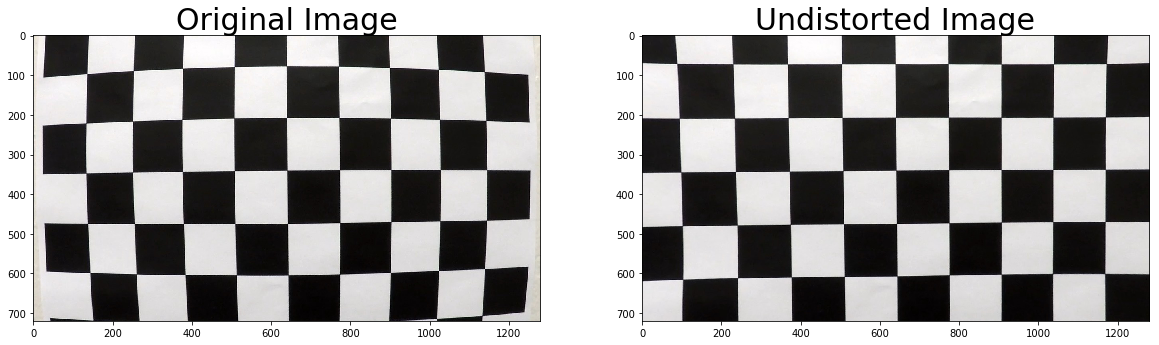

In [2]:
camera = Camera()

camera.calibrate("./camera_cal/*.jpg")

# Read test image
image = im.imread("camera_cal/calibration1.jpg")
dst   = camera.undistort(image)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [58]:
from thresholding import *
def gradients(image):
    HSV      = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_mask = color_mask(HSV, 
                          np.array([0, 100 ,90]), np.array([22, 220, 255]), 
                          np.array([0, 0, 219]), np.array([180, 25, 255]))
    
    YUV     = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    yuv_mask = color_mask(YUV, 
                         np.array([0, 0 , 0]),   np.array([255,255, 105]), 
                         np.array([0, 239, 255]),np.array([255, 255, 255]))
    

    color = cv2.bitwise_or(yuv_mask, hsv_mask)

    combined_binary = np.zeros_like(color)
    combined_binary[(color==255)] = 1

    return combined_binary.astype(np.uint8)

In [59]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def draw_fit(binary_image, leftx, lefty,rightx,righty,left_fit, right_fit, margin=60):
    y = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
   
    left_fitx  = left_fit[0] * y**2+left_fit[1]*y+left_fit[2]
    right_fitx = right_fit[0] * y**2+right_fit[1]*y+right_fit[2]

    # Create output image
    out_image = np.dstack((binary_image, binary_image, binary_image))*255
    window_img = np.zeros_like(out_image)
    
    out_image[lefty,  leftx]  = [255,0,0]
    out_image[righty, rightx] = [0,0,255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, y]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  y])))])

    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, y]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  y])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_image, 1, window_img, 0.3, 0)
    return result

def find_lane_using_previous_fit(image, left_line, right_line, margin = 60):
    current_left_fit  = left_line.current_fit[-1]
    current_right_fit = right_line.current_fit[-1] 


    nonzero = image.nonzero()
    y       = np.array(nonzero[0])
    x       = np.array(nonzero[1])
    

    left_lane_inds = ((x > (current_left_fit[0]*(y**2) + current_left_fit[1]*y +  current_left_fit[2] - margin)) & 
                      (x < (current_left_fit[0]*(y**2) + current_left_fit[1]*y + current_left_fit[2] + margin))) 

    right_lane_inds = ((x > (current_right_fit[0]*(y**2) + current_right_fit[1]*y + current_right_fit[2] - margin)) & 
                       (x < (current_right_fit[0]*(y**2) + current_right_fit[1]*y + current_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = x[left_lane_inds]
    lefty = y[left_lane_inds] 
    rightx = x[right_lane_inds]
    righty = y[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty


def find_lines(image, nwindows=9):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

    # Find left and right peak
    midpoint = np.int(histogram.shape[0]/2) # Mid point
    left_base= np.argmax(histogram[:midpoint])
    right_base= np.argmax(histogram[midpoint:]) + midpoint

    # Height of window
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x, y points of all . onseros pixls
    nonzero  = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions of all none zeros pixels
    left_current  = left_base
    right_current = right_base
    # Set width of window +/- margin
    margin = 60
    # set number of pixels found to recenter window
    minpix = 50

    left_lane_inds  = []
    right_lane_inds = []

    for window in range(nwindows):
        # identify window boundaries x/y and Left/Right
        win_y_low       = image.shape[0] - (window+1)*window_height
        win_y_high      = image.shape[0] - window*window_height
        win_xleft_low   = left_current - margin
        win_xleft_high  = left_current + margin
        win_xright_low  = right_current - margin
        win_xright_high = right_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds= ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & 
                                                     (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append new indices
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_current= np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds  = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit= np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

In [60]:
def mark_lane(image, binary_warped, left_fit, right_fit, Minv):
    # Fit polynomial for the left and right lines 
    y      = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    xleft  = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    xright = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
  
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left  = np.array([np.transpose(np.vstack([xleft, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([xright, y])))])
    pts       = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(image, 1, newwarp, 0.3, 0)

def get_perspective_transform(image_size, src, dst):
    src = np.float32(src)
    dst = np.float32(dst)

    M    = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

def get_points(image):
    image_size = image.shape[0:2]
    height     = image_size[0]
    width      = image_size[1]

    src = np.array([[(width * 0.145, height), (width * 0.42, 0.65 * height), 
                     (0.582 * width, height * 0.65), (0.898 * width, height)]], dtype=np.int32)
    dst = np.array([[(0.27 * width, height), (0.27 * width, 0), 
                     (0.77 * width, 0), (0.77 * width, height)]], dtype=np.int32)
    return src, dst

def region_of_interest(binary_image, points):
    mask = np.zeros_like(binary_image, dtype=np.uint8)

    # Create mask interest region
    cv2.fillPoly(mask, points, 255)
    
    # Mask area outside the 
    return cv2.bitwise_and(binary_image, mask)

def compute_curvature(height, fit, y):
    x      = fit[0] * y**2 + fit[1] * y + fit[2]
    y_eval = y[-1]
        
    # Fit new polynomials to x,y in world space
    fit_cr= np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    curverad = np.round(curverad, 2)

    return curverad

def isGoodLane(binary_warped, left_fit, right_fit):
    y      = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    xleft  = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    xright = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
    width  = np.mean(xright - xleft)
    
    return (width >500 and width < 700)
    

In [61]:
class Lane(object):
    def __init__(self, camera):
        self.nframes        = 5
        self.camera         = camera
        self.M              = None
        self.Minv           = None
        self.src            = None
        self.dst            = None
        self.left_line      = Line()
        self.right_line     = Line()
        self.detected       = False
        
    def detect(self, image):
        # Calculate matrix transformation
        image_size    = (image.shape[1], image.shape[0])
        if self.M is None:
            self.src, self.dst = get_points(image)
            self.M, self.Minv  = get_perspective_transform(image_size, self.src, self.dst)
            
        # 1. undistort image
        undistorted_image = self.camera.undistort(image)

        # 2. Gradients
        binary = gradients(undistorted_image)

        # 3. warp
        #binary        = region_of_interest(binary, self.src)
        binary_warped = cv2.warpPerspective(binary, self.M, image_size, flags=cv2.INTER_LINEAR)

        # 4. Find lane
        if self.detected:
            left_fit, right_fit, leftx, lefty, rightx, righty = find_lane_using_previous_fit(binary_warped, self.left_line, self.right_line)
        else:
            left_fit, right_fit, leftx, lefty, rightx, righty = find_lines(binary_warped)
       
        out = draw_fit(binary_warped, leftx, lefty, rightx, righty, left_fit, right_fit, margin=100)
        
        if isGoodLane(binary_warped, left_fit, right_fit):
            self.detected = True
            self.left_line.current_fit.append(left_fit)
            self.right_line.current_fit.append(right_fit)
        else:
            self.detected = False
        
        if len(self.left_line.current_fit) > self.nframes:
            self.left_line.current_fit  = self.left_line.current_fit[1:]
            self.right_line.current_fit = self.right_line.current_fit[1:]
        
        
        self.left_line.best_fit = np.mean(self.left_line.current_fit, axis=0)
        self.right_line.best_fit = np.mean(self.right_line.current_fit, axis=0)
        
        # 5. Mark lanes
        return mark_lane(undistorted_image, binary_warped, self.left_line.best_fit, self.right_line.best_fit, self.Minv),out,binary_warped,binary

In [7]:
def save_lane(filename, lane):
    with open(filename, "wb") as file:
        pickle.dump(lane, file, protocol=pickle.HIGHEST_PROTOCOL)

def load_lane(filename):
    with open(filename, "rb") as file:
        return pickle.load(file)

    
save_lane("lane.p", lane)
    

NameError: name 'lane' is not defined

In [62]:
lane = Lane(camera)
def process_images(camera, lane):
    
    for frame in range(1,1261):
        #print("Frame {}".format(frame))
        image = plt.imread("./frames/frame-{0:04d}.jpg".format(frame))
        yield image, lane.detect(image)
process = process_images(camera, lane)

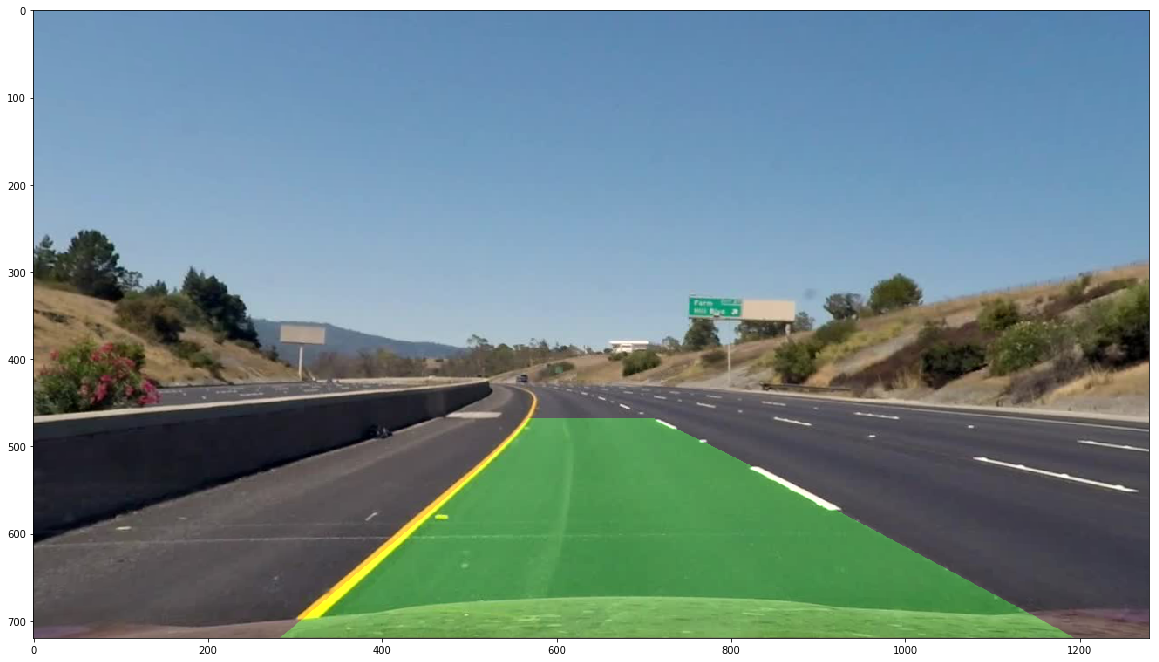

In [63]:
for i in range(1):
    image, (marked_image,out,binary_warped,binary)  = next(process)
plt.figure(figsize=(20,20))
plt.imshow(marked_image)

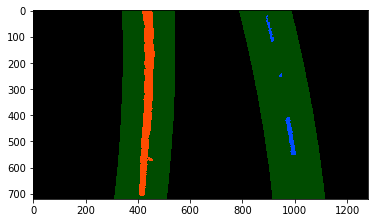

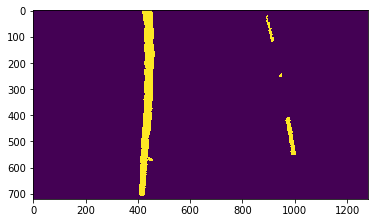

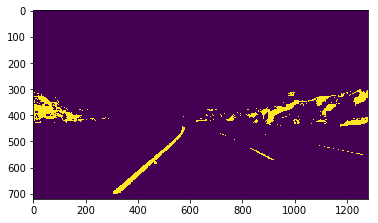

In [64]:
plt.figure()
plt.imshow(out)
plt.figure()
plt.imshow(binary_warped)
plt.figure()
plt.imshow(binary)

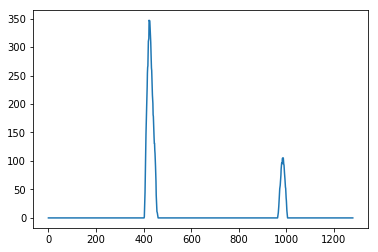

In [65]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [66]:
lane = Lane(camera)
def process_frame(frame):
    global lane
    image,out,binary_warped,binary= lane.detect(frame)
    #mask = gradients(frame)
    
    part1 = cv2.resize(out,(0,0),fx=0.25, fy=0.25)
    part2 = cv2.resize(cv2.bitwise_and(frame, frame, mask=binary),(0,0),fx=0.25, fy=0.25)
    
    image[50:230, 900:1220] = part2
    image[50:230, 400:720] = part1
    return image
    

video_output1 = 'project_video_output_all.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_frame)
processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output_all.mp4
[MoviePy] Writing video project_video_output_all.mp4


100%|█████████▉| 1260/1261 [01:42<00:00, 12.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_all.mp4 



In [108]:
with open("camera.p", "wb") as file:
    pickle.dump(camera, file, protocol=pickle.HIGHEST_PROTOCOL)
    

In [162]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction =  np.arctan2(abs_sobely , abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    abs_sobel = np.absolute(sobel)
    # 5) Create a mask of 1's where the scaled gradient magnitude
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

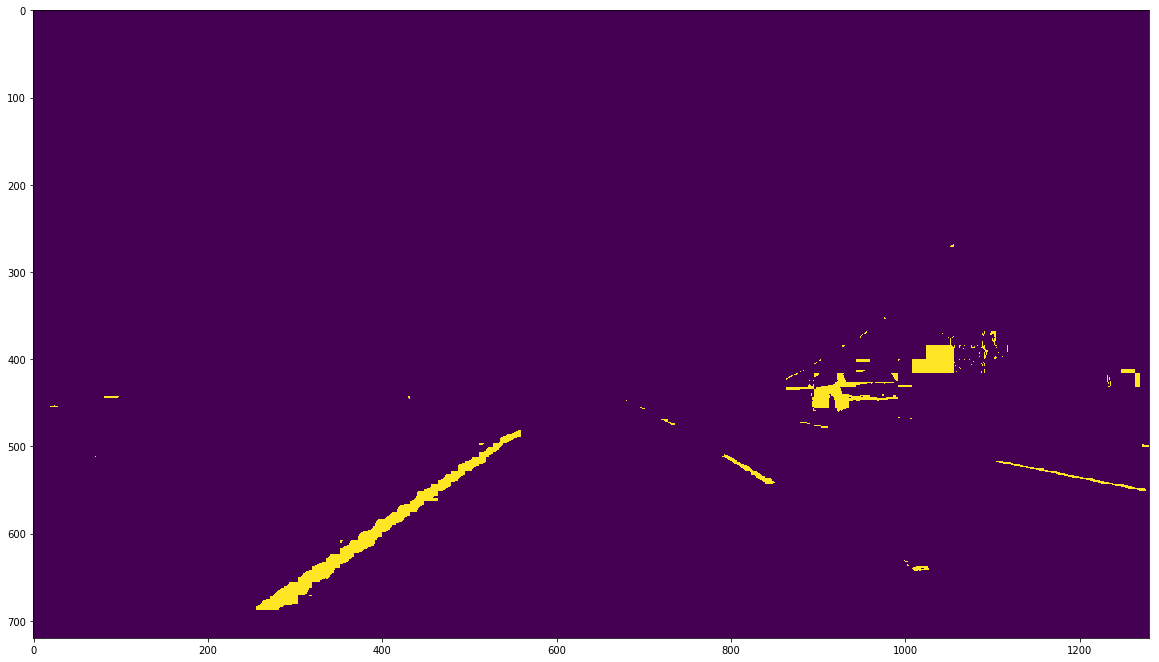

In [57]:
image = plt.imread('./frames/frame-0568.jpg')
bin   = gradients(image)

plt.figure(figsize=(20,20))
plt.imshow(bin)